# Instalaciones

In [ ]:
!pip install pydicom
!pip install SimpleITK

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.0 MB 8.6 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 48.4 MB 17 kB/s 


# Librerías

In [ ]:
#otros
import os
import re
import cv2
import shutil
import pickle
from glob import glob
from PIL import Image

#basicos
import numpy as np
import pandas as pd

#visualización
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
%matplotlib inline

#red nuronal 
import tensorflow as tf
from keras import optimizers
import sklearn.metrics as metrics
from keras.regularizers import l2
from keras.models import Sequential
from keras.optimizer_v2.adam import Adam
from keras.callbacks import ModelCheckpoint
from keras.utils.vis_utils import model_to_dot
from keras.optimizer_v2.rmsprop import RMSprop
from keras.optimizer_experimental.sgd import SGD
from keras.metrics import categorical_accuracy
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from keras.models import Sequential, load_model, Model
from sklearn.metrics import ConfusionMatrixDisplay
from keras_preprocessing.image.dataframe_iterator import DataFrameIterator
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.layers import Conv2D,Conv3D,Lambda, BatchNormalization,MaxPooling2D,MaxPooling3D, Flatten,Input
from keras.layers import Dense, Dropout, GlobalAveragePooling2D,InputLayer,LeakyReLU,Concatenate
#dicom
import pydicom as dicom

#mhd
import SimpleITK as sitk


In [ ]:
#otros
import os
import re
import cv2
import shutil
import pickle
from glob import glob


#basicos
import numpy as np
import pandas as pd

#visualización
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
%matplotlib inline

#red nuronal 
import tensorflow as tf
from keras import optimizers
from keras.regularizers import l2
from keras.models import Sequential
from keras.optimizer_v2.adam import Adam
from keras.callbacks import ModelCheckpoint
from keras.utils.vis_utils import model_to_dot
from keras.optimizer_v2.rmsprop import RMSprop
from keras.optimizer_experimental.sgd import SGD
from keras.metrics import categorical_accuracy
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from keras.models import Sequential, load_model, Model
from keras_preprocessing.image.dataframe_iterator import DataFrameIterator
from keras_preprocessing.image.directory_iterator import DirectoryIterator
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.layers import Conv2D,Conv3D,Lambda, BatchNormalization,MaxPooling2D,MaxPooling3D, Flatten,Input
from keras.layers import Dense, Dropout, GlobalAveragePooling2D,InputLayer,LeakyReLU,Concatenate



# Funciones auxiliares

In [ ]:
class DicomDataGen(tf.keras.utils.Sequence):
    
    def __init__(self, df, X_col, y_col,
                 batch_size,
                 input_size=(224, 224, 19),
                 shuffle=True,
                 image_data_generator=None):
        
        self.df = df.copy()
        self.X_col = X_col
        self.y_col = y_col
        self.batch_size = batch_size
        self.input_size = input_size
        self.shuffle = shuffle
        self.image_data_generator=image_data_generator

        self.n = len(self.df)
        self.n_name = df[y_col['name']].nunique()
    
    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)
    
    def __get_input(self, dcm_path, target_size):
    
        dicoms=[]
        cont=0
        files_patients=sorted(glob(dcm_path+'/*'))
        dicoms=np.zeros((len(files_patients),)+target_size)
        for file_dcm in files_patients:
          image_array = dicom.dcmread(file_dcm).pixel_array
          image_array = cv2.resize(image_array, target_size[0:2], interpolation=cv2.INTER_NEAREST)  
          dicoms[cont]=image_array/255. 
          cont+=1
        dicoms=np.array(dicoms,dtype='f')
        # dicoms=dicoms.reshape((dicoms.shape[1], dicoms.shape[2],dicoms.shape[0]))
        return dicoms

    def __get_output(self, label, num_classes):
        return np.array(label,dtype='f')
    
    def __get_data(self, batches):
        # Generates data containing batch_size samples

        path_batch = batches[self.X_col['path']]
              
        name_batch = batches[self.y_col['name']]

        X_batch = np.expand_dims(np.asarray([self.__get_input(x, self.input_size) for x in path_batch]), 1)

        y0_batch = np.asarray([self.__get_output(y, self.n_name) for y in name_batch])

        if self.image_data_generator is not None:
          for i, (x, y1) in enumerate(zip(X_batch, y0_batch)):
              transform_params = self.image_data_generator.get_random_transform((1,)+self.input_size)
              for k,j in enumerate(x[0]):
                X_batch[i][0][k] = self.image_data_generator.apply_transform(np.expand_dims(j,axis=-1), transform_params)[:,:,0]/255

        return X_batch, y0_batch
    
    def __getitem__(self, index):
        
        batches = self.df[index * self.batch_size:(index + 1) * self.batch_size]
        X, y = self.__get_data(batches)        
        return X, y
    
    def __len__(self):
        return self.n // self.batch_size

In [ ]:
class MHDDataGen(tf.keras.utils.Sequence):
    
    def __init__(self, df, X_col, y_col,
                 batch_size,
                 input_size=(224, 224, 19),
                 shuffle=True,
                 image_data_generator=None):
        
        self.df = df.copy()
        self.X_col = X_col
        self.y_col = y_col
        self.batch_size = batch_size
        self.input_size = input_size
        self.shuffle = shuffle
        self.image_data_generator=image_data_generator
        
        self.n = len(self.df)
        self.n_name = df[y_col['name']].nunique()
    
    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)
    
    def __get_input(self, mhd_path, target_size):
    
        dicoms=[]
        cont=0
        itkimage = sitk.ReadImage(mhd_path)
        ct_scan = sitk.GetArrayFromImage(itkimage)
        dicoms=np.zeros((ct_scan.shape[0],)+target_size)
        for mhd_image in ct_scan:
          image_array = cv2.resize(mhd_image, target_size[0:2], interpolation=cv2.INTER_NEAREST)  
          dicoms[cont,:,:]=image_array/255. 
          cont+=1
        dicoms=np.array(dicoms,dtype='f')
        # dicoms=dicoms.reshape((dicoms.shape[1], dicoms.shape[2],dicoms.shape[0]))
        return dicoms

    def __get_output(self, label, num_classes):
        return np.array(label,dtype='f')
    
    def __get_data(self, batches):
        # Generates data containing batch_size samples

        path_batch = batches[self.X_col['path']]
              
        name_batch = batches[self.y_col['name']]

        X_batch = np.expand_dims(np.asarray([self.__get_input(x, self.input_size) for x in path_batch]), 1)

        y0_batch = np.asarray([self.__get_output(y, self.n_name) for y in name_batch])

        if self.image_data_generator is not None:
          for i, (x, y1) in enumerate(zip(X_batch, y0_batch)):
              transform_params = self.image_data_generator.get_random_transform((1,)+self.input_size)
              for k,j in enumerate(x[0]):
                X_batch[i][0][k] = self.image_data_generator.apply_transform(np.expand_dims(j,axis=-1), transform_params)[:,:,0]/255

        return X_batch, y0_batch
    
    def __getitem__(self, index):
        
        batches = self.df[index * self.batch_size:(index + 1) * self.batch_size]
        X, y = self.__get_data(batches)        
        return X, y
    
    def __len__(self):
        return self.n // self.batch_size

In [ ]:
from IPython.display import SVG
from IPython.display import clear_output

def display_model(model):
    if COLAB:
        display(SVG(model_to_dot(model, show_shapes=True,dpi=72).create(prog='dot', format='svg')))
    else:
        display(SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg')))

In [ ]:
def grafica_entrenamiento(tr_acc, val_acc, tr_loss, val_loss, best_i,
                          figsize=(10,4)):
    plt.figure(figsize=figsize)
    ax = plt.subplot(1,2,1)
    plt.plot(1+np.arange(len(tr_acc)),  100*np.array(tr_acc))
    plt.plot(1+np.arange(len(val_acc)), 100*np.array(val_acc))
    plt.plot(1+best_i, 100*val_acc[best_i], 'or')
    plt.title('tasa de acierto del modelo (%)', fontsize=18)
    plt.ylabel('tasa de acierto (%)', fontsize=18)
    plt.xlabel('época', fontsize=18)
    plt.legend(['entrenamiento', 'validación'], loc='upper left')
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))

    plt.subplot(1,2,2)
    plt.plot(1+np.arange(len(tr_acc)), np.array(tr_loss))
    plt.plot(1+np.arange(len(val_acc)), np.array(val_loss))
    plt.plot(1+best_i, val_loss[best_i], 'or')
    plt.title('loss del modelo', fontsize=18)
    plt.ylabel('loss', fontsize=18)
    plt.xlabel('época', fontsize=18)
    plt.legend(['entrenamiento', 'validación'], loc='upper left')
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.show()

In [ ]:
def compute_metrics(model, testgen_model, y_test, y_pred,factor):
  y_pred_proba = model.predict(testgen_model)
  [fpr, tpr, thr] = metrics.roc_curve(y_test, 10*y_pred_proba)

  y_pred=[True if pred[0]>factor else False for pred in y_pred]
  mcm = metrics.confusion_matrix(y_test, y_pred)
  tn = mcm[0, 0]
  tp = mcm[1, 1]
  fn = mcm[1, 0]
  fp = mcm[0, 1]

  Specificity = tn / (tn + fp)

  print('Train/Test split results:')
  print('CNN'+" accuracy is %2.3f" % metrics.accuracy_score(y_test, y_pred))
  print('CNN'+" auc is %2.3f" % metrics.auc(fpr, tpr))
  print('CNN'+" Sensitivity is %2.3f" % metrics.recall_score(y_test, y_pred))
  print('CNN'+" Specificity is %2.3f" % Specificity) 
  # print('CNN'+" F1 is %2.3f" % metrics.f1_score(y_test, y_pred))

# Importar dataset

In [ ]:
COLAB = True

In [ ]:
if COLAB:
    from google.colab import drive
    drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
models_paths=sorted(glob('/content/drive/MyDrive/Capstone/Modelos'+'/*.h5'))

In [ ]:
models_paths

['/content/drive/MyDrive/Capstone/Modelos/model_current_best_DYNDIST0.h5',
 '/content/drive/MyDrive/Capstone/Modelos/model_current_best_DYNDIST1.h5',
 '/content/drive/MyDrive/Capstone/Modelos/model_current_best_DYNDIST2.h5',
 '/content/drive/MyDrive/Capstone/Modelos/model_current_best_DYNDISTCALC_BVAL0.h5',
 '/content/drive/MyDrive/Capstone/Modelos/model_current_best_adc.h5',
 '/content/drive/MyDrive/Capstone/Modelos/model_current_best_ktrans.h5',
 '/content/drive/MyDrive/Capstone/Modelos/model_current_best_t2_tse_cor0.h5',
 '/content/drive/MyDrive/Capstone/Modelos/model_current_best_t2_tse_sag0.h5',
 '/content/drive/MyDrive/Capstone/Modelos/model_current_best_t2_tse_tra0.h5',
 '/content/drive/MyDrive/Capstone/Modelos/model_current_best_tfl0_tra.h5',
 '/content/drive/MyDrive/Capstone/Modelos/model_current_best_tfl_fast0.h5',
 '/content/drive/MyDrive/Capstone/Modelos/model_current_best_tfl_tra.h5']

In [ ]:
models_paths_f=models_paths[4:8]
models_paths_f.append(models_paths[-1])
models_paths_f

['/content/drive/MyDrive/Capstone/Modelos/model_current_best_adc.h5',
 '/content/drive/MyDrive/Capstone/Modelos/model_current_best_ktrans.h5',
 '/content/drive/MyDrive/Capstone/Modelos/model_current_best_t2_tse_cor0.h5',
 '/content/drive/MyDrive/Capstone/Modelos/model_current_best_t2_tse_sag0.h5',
 '/content/drive/MyDrive/Capstone/Modelos/model_current_best_tfl_tra.h5']

In [ ]:
models=[]
for model in models_paths_f:
  models.append(load_model(model,compile=False))

In [ ]:
tr_df_all_mhd=pickle.load(open("/content/drive/MyDrive/Capstone/PROSTATEX_dataset/pickles/tr_df_all_mhd.pickle","rb"))
val_df_all_mhd=pickle.load(open("/content/drive/MyDrive/Capstone/PROSTATEX_dataset/pickles/val_df_all_mhd.pickle","rb"))
test_df_all_mhd=pickle.load(open("/content/drive/MyDrive/Capstone/PROSTATEX_dataset/pickles/test_df_all_mhd.pickle","rb"))
tr_df_all_dcm=pickle.load(open("/content/drive/MyDrive/Capstone/PROSTATEX_dataset/pickles/tr_df_all_dcm.pickle","rb"))
val_df_all_dcm=pickle.load(open("/content/drive/MyDrive/Capstone/PROSTATEX_dataset/pickles/val_df_all_dcm.pickle","rb"))
test_df_all_dcm=pickle.load(open("/content/drive/MyDrive/Capstone/PROSTATEX_dataset/pickles/test_df_all_dcm.pickle","rb"))

# Cálculo de métricas


## Ktrans

In [ ]:

test_augmentation_parameters = dict(
    # rescale=1.0/255.0
)

# training parameters
BATCH_SIZE = 1
CLASS_MODE = 'binary'
COLOR_MODE = 'grayscale'
TARGET_SIZE = (300, 300)
EPOCHS = 50
SEED = 1337


test_consts = {
    'batch_size': 1,  # should be 1 in testing
    'class_mode': CLASS_MODE,
    'color_mode': COLOR_MODE,
    'target_size': TARGET_SIZE,  # resize input images
    'shuffle': False
}

In [ ]:
testgen=MHDDataGen(test_df_all_mhd,
                   X_col={'path':'path_dcm'},
                   y_col={'name': 'clinSig'},
                   shuffle=False,
                   batch_size=1, input_size=TARGET_SIZE)

In [ ]:
y_pred_ktrans=models[1].predict(testgen)

In [ ]:
y_test=np.array([list(y)[0] for X,y in testgen])

In [ ]:
max(y_pred_ktrans),min(y_pred_ktrans)

(array([0.49312195], dtype=float32), array([0.4921924], dtype=float32))

In [ ]:
len(y_test),sum(y_test)

(95, 25.0)

In [ ]:
sum(True if pred[0]>0.27 else False for pred in y_pred_ktrans)

95

In [ ]:
compute_metrics(models[1],testgen,y_test,y_pred_ktrans,0.26)

Train/Test split results:
CNN accuracy is 0.263
CNN auc is 0.450
CNN Sensitivity is 1.000
CNN Specificity is 0.000
CNN F1 is 0.417


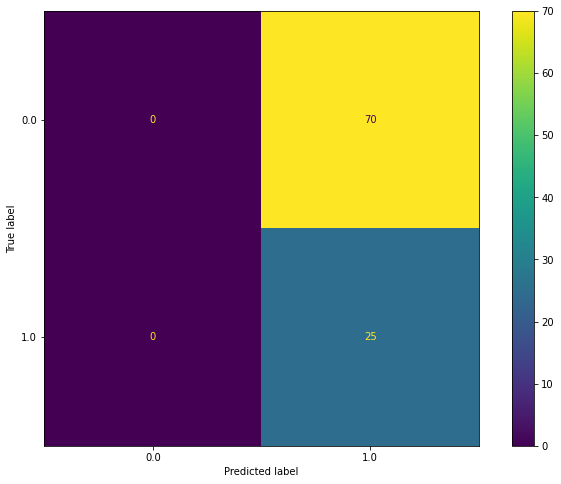

In [ ]:
fig, ax = plt.subplots(figsize=(12, 8))
ConfusionMatrixDisplay.from_predictions(y_test, [True if pred[0]>0.26 else False for pred in y_pred_ktrans],ax=ax);

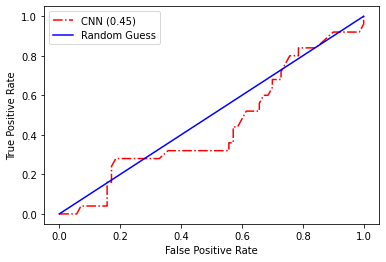

In [ ]:
clase_positiva = 1
fpr, tpr, thresholds = roc_curve(y_test==clase_positiva, y_pred_ktrans)
fig, ax1 = plt.subplots(1,1)
ax1.plot(fpr, tpr, 'r-.', label = 'CNN (%2.2f)' % auc(fpr, tpr))
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.plot(fpr, fpr, 'b-', label = 'Random Guess')
ax1.legend();

## tfl_tra

In [ ]:
mri_types=sorted(list(tr_df_all_dcm['name'].value_counts().index))
mri_types

['ep2d_diff_tra_DYNDIST0',
 'ep2d_diff_tra_DYNDIST1',
 'ep2d_diff_tra_DYNDIST2',
 'ep2d_diff_tra_DYNDISTCALC_BVAL0',
 'ep2d_diff_tra_DYNDIST_ADC0',
 't2_tse_cor0',
 't2_tse_sag0',
 't2_tse_tra0',
 'tfl_3d_PD_ref_tra_1_5x1_5_t30',
 'tfl_3d_dynamisch_fast0']

In [ ]:
mri_types_f=[mri_types[4],mri_types[5],mri_types[6],mri_types[-2]]
mri_types_f

['ep2d_diff_tra_DYNDIST_ADC0',
 't2_tse_cor0',
 't2_tse_sag0',
 'tfl_3d_PD_ref_tra_1_5x1_5_t30']

In [ ]:
mri_types_f[-1]

'tfl_3d_PD_ref_tra_1_5x1_5_t30'

In [ ]:
mri=mri_types_f[-1]

tr_df_all_adc=tr_df_all_dcm[tr_df_all_dcm['name']==mri]
val_df_all_adc=val_df_all_dcm[val_df_all_dcm['name']==mri]
test_df_all_adc=test_df_all_dcm[test_df_all_dcm['name']==mri]

testgen=DicomDataGen(test_df_all_adc,
                   X_col={'path':'path_dcm'},
                   y_col={'name': 'clinSig'},
                   shuffle=False,
                   batch_size=1, input_size=TARGET_SIZE)

In [ ]:
y_pred_tfl_tra=models[-1].predict(testgen)

In [ ]:
y_pred_tfl_tra=y_pred_tfl_tra*10
y_pred_tfl_tra

array([[0.06078631],
       [0.05665942],
       [0.05665942],
       [0.00633992],
       [0.06078631],
       [0.00956183],
       [0.00956183],
       [0.01771547],
       [0.01771547],
       [0.00815345],
       [0.00633992],
       [0.0222024 ],
       [0.03634204],
       [0.02062675],
       [0.02062675],
       [0.0074847 ],
       [0.0222024 ],
       [0.01529639],
       [0.09546515],
       [0.03178632],
       [0.0197823 ],
       [0.0197823 ],
       [0.19805509],
       [0.00520344],
       [0.01114722],
       [0.10743678],
       [0.22765005],
       [0.00537244],
       [0.10743678],
       [0.01114722],
       [0.01114722],
       [0.01124442],
       [0.10743678],
       [0.00537244],
       [0.05665942],
       [0.0259188 ],
       [0.02703771],
       [0.07802817],
       [0.03071305],
       [0.01529639],
       [0.06727866],
       [0.06078631],
       [0.2685144 ],
       [0.02703771],
       [0.03083658],
       [0.00478445],
       [0.02703771],
       [0.027

In [ ]:
y_test=np.array([list(y)[0] for X,y in testgen])

In [ ]:
max(y_pred_tfl_tra),min(y_pred_tfl_tra)

(array([0.2685144], dtype=float32), array([0.00135164], dtype=float32))

In [ ]:
len(y_test),len(y_pred_tfl_tra)

(98, 98)

In [ ]:
sum(True if pred[0]>0.01 else False for pred in y_pred_tfl_tra)

77

In [ ]:
sum(y_test)

23.0

In [ ]:
compute_metrics(models[-1],testgen,y_test,y_pred_tfl_tra,0.01)

Train/Test split results:
CNN accuracy is 0.286
CNN auc is 0.409
CNN Sensitivity is 0.652
CNN Specificity is 0.173
CNN F1 is 0.300


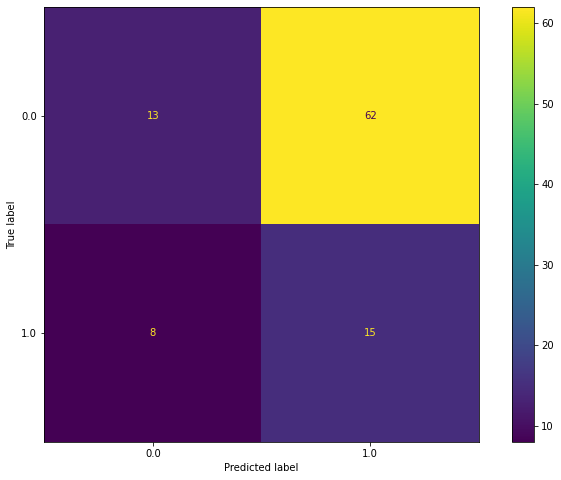

In [ ]:
fig, ax = plt.subplots(figsize=(12, 8))
ConfusionMatrixDisplay.from_predictions(y_test, [True if pred[0]>0.01 else False for pred in y_pred_tfl_tra],ax=ax);

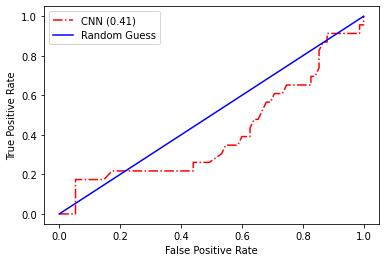

In [ ]:
clase_positiva = 1
fpr, tpr, thresholds = roc_curve(y_test==clase_positiva, y_pred_tfl_tra)
fig, ax1 = plt.subplots(1,1)
ax1.plot(fpr, tpr, 'r-.', label = 'CNN (%2.2f)' % auc(fpr, tpr))
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.plot(fpr, fpr, 'b-', label = 'Random Guess')
ax1.legend();

## ADC

In [ ]:
mri_types_f

['ep2d_diff_tra_DYNDIST_ADC0',
 't2_tse_cor0',
 't2_tse_sag0',
 'tfl_3d_PD_ref_tra_1_5x1_5_t30']

In [ ]:
mri_types_f[0]

'ep2d_diff_tra_DYNDIST_ADC0'

In [ ]:
mri=mri_types_f[0]

tr_df_all_adc=tr_df_all_dcm[tr_df_all_dcm['name']==mri]
val_df_all_adc=val_df_all_dcm[val_df_all_dcm['name']==mri]
test_df_all_adc=test_df_all_dcm[test_df_all_dcm['name']==mri]

valgen = DicomDataGen(val_df_all_adc,
                    X_col={'path':'path_dcm'},
                    y_col={'name': 'clinSig'},
                    batch_size=BATCH_SIZE, input_size=TARGET_SIZE)

testgen=DicomDataGen(test_df_all_adc,
                   X_col={'path':'path_dcm'},
                   y_col={'name': 'clinSig'},
                   shuffle=False,
                   batch_size=1, input_size=TARGET_SIZE)

In [ ]:
y_pred_adc=models[0].predict(testgen)

In [ ]:
y_pred_val_adc=models[0].predict(valgen)

In [ ]:
y_pred_adc=y_pred_adc*10

In [ ]:
y_pred_val_adc=y_pred_val_adc*10

In [ ]:
y_test=np.array([list(y)[0] for X,y in testgen])
y_val=np.array([list(y)[0] for X,y in valgen])

In [ ]:
max(y_pred_adc),min(y_pred_adc)

(array([0.2533357], dtype=float32), array([0.01732112], dtype=float32))

In [ ]:
len(y_test),len(y_pred_adc)

(59, 59)

In [ ]:
compute_metrics(models[0],testgen,y_test,y_pred_adc,0.12)

Train/Test split results:
CNN accuracy is 0.678
CNN auc is 0.515
CNN Sensitivity is 0.125
CNN Specificity is 0.884


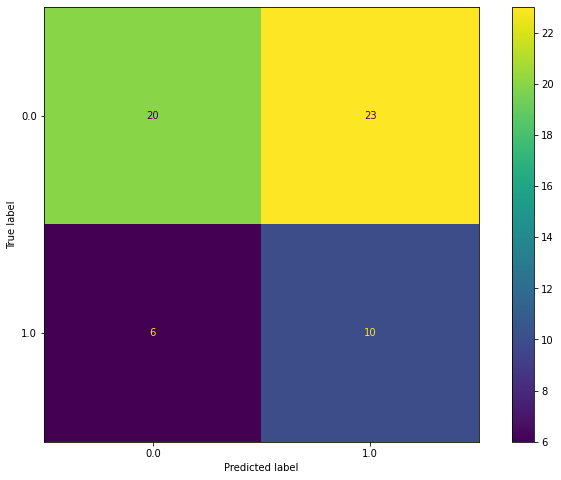

In [ ]:
fig, ax = plt.subplots(figsize=(12, 8))
ConfusionMatrixDisplay.from_predictions(y_test, [True if pred[0]>0.07 else False for pred in y_pred_adc],ax=ax);

In [ ]:
compute_metrics(models[0],valgen,y_val,y_pred_val_adc,0.07)

Train/Test split results:
CNN accuracy is 0.700
CNN auc is 0.617
CNN Sensitivity is 0.750
CNN Specificity is 0.696


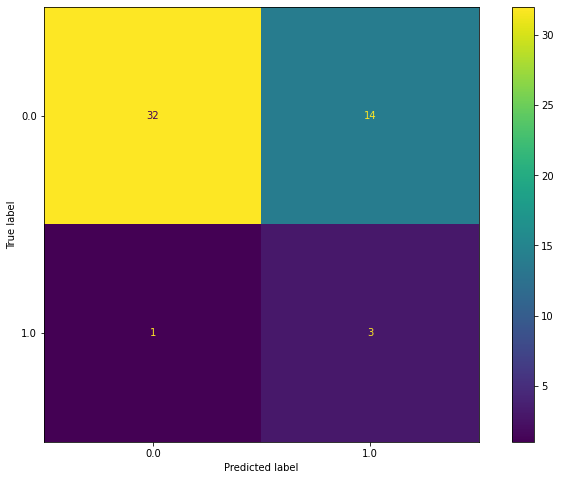

In [ ]:
fig, ax = plt.subplots(figsize=(12, 8))
ConfusionMatrixDisplay.from_predictions(y_val, [True if pred[0]>0.07 else False for pred in y_pred_val_adc],ax=ax);

## t2_tse_cor0

In [ ]:
mri_types_f

['ep2d_diff_tra_DYNDIST_ADC0',
 't2_tse_cor0',
 't2_tse_sag0',
 'tfl_3d_PD_ref_tra_1_5x1_5_t30']

In [ ]:
mri_types_f[1]

't2_tse_cor0'

In [ ]:
mri=mri_types_f[1]

tr_df_all_adc=tr_df_all_dcm[tr_df_all_dcm['name']==mri]
val_df_all_adc=val_df_all_dcm[val_df_all_dcm['name']==mri]
test_df_all_adc=test_df_all_dcm[test_df_all_dcm['name']==mri]

testgen=DicomDataGen(test_df_all_adc,
                   X_col={'path':'path_dcm'},
                   y_col={'name': 'clinSig'},
                   shuffle=False,
                   batch_size=1, input_size=TARGET_SIZE)

In [ ]:
y_pred_t2_cor=models[2].predict(testgen)

In [ ]:
y_pred_t2_cor

array([[0.49805737],
       [0.49805737],
       [0.49622416],
       [0.49622416],
       [0.49199867],
       [0.49805737],
       [0.49296007],
       [0.49891898],
       [0.4977061 ],
       [0.49196172],
       [0.48783168],
       [0.496917  ],
       [0.48783168],
       [0.49891898],
       [0.49891898],
       [0.49891898],
       [0.49200344],
       [0.49200344],
       [0.49355477],
       [0.48997486],
       [0.49765483],
       [0.49765483],
       [0.49355477],
       [0.4949358 ],
       [0.4949358 ],
       [0.4949358 ],
       [0.49579564],
       [0.48920274],
       [0.49622416],
       [0.49072236],
       [0.49196172],
       [0.49891898],
       [0.49891898],
       [0.49444452],
       [0.49444452],
       [0.4941561 ],
       [0.4941561 ],
       [0.49334314],
       [0.49493366],
       [0.49167752],
       [0.49891898],
       [0.49388433],
       [0.49388433],
       [0.49369523],
       [0.49383175],
       [0.49069333],
       [0.49322617],
       [0.490

In [ ]:
y_test=np.array([list(y)[0] for X,y in testgen])

In [ ]:
max(y_pred_t2_cor),min(y_pred_t2_cor)

(array([0.49891898], dtype=float32), array([0.48783168], dtype=float32))

In [ ]:
len(y_test),len(y_pred_t2_cor)

(50, 50)

In [ ]:
sum(True if pred[0]>0.27 else False for pred in y_pred_t2_cor)

50

In [ ]:
compute_metrics(models[2],testgen,y_test,y_pred_t2_cor,0.49)

Train/Test split results:
CNN accuracy is 0.240
CNN auc is 0.336
CNN Sensitivity is 0.833
CNN Specificity is 0.053
CNN F1 is 0.345


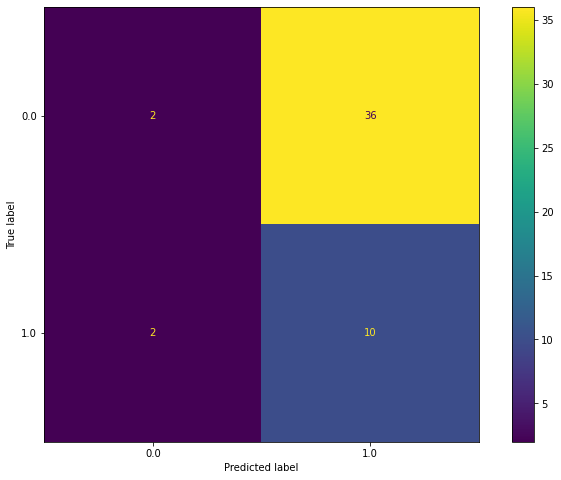

In [ ]:
fig, ax = plt.subplots(figsize=(12, 8))
ConfusionMatrixDisplay.from_predictions(y_test, [True if pred[0]>0.49 else False for pred in y_pred_t2_cor],ax=ax);

## t2_tse_sag0

In [ ]:
mri_types_f

['ep2d_diff_tra_DYNDIST_ADC0',
 't2_tse_cor0',
 't2_tse_sag0',
 'tfl_3d_PD_ref_tra_1_5x1_5_t30']

In [ ]:
mri_types_f[2]

't2_tse_sag0'

In [ ]:
mri=mri_types_f[2]

tr_df_all_adc=tr_df_all_dcm[tr_df_all_dcm['name']==mri]
val_df_all_adc=val_df_all_dcm[val_df_all_dcm['name']==mri]
test_df_all_adc=test_df_all_dcm[test_df_all_dcm['name']==mri]

testgen=DicomDataGen(test_df_all_adc,
                   X_col={'path':'path_dcm'},
                   y_col={'name': 'clinSig'},
                   shuffle=False,
                   batch_size=1, input_size=TARGET_SIZE)

In [ ]:
y_pred_t2_sag=models[3].predict(testgen)

In [ ]:
y_pred_t2_sag

array([[0.06498554],
       [0.04854992],
       [0.07344189],
       [0.10516706],
       [0.12795016],
       [0.05034092],
       [0.07162911],
       [0.09056482],
       [0.12795016],
       [0.07348359],
       [0.15049654],
       [0.06620553],
       [0.06620553],
       [0.07119671],
       [0.11659694],
       [0.07846603],
       [0.07742175],
       [0.05884218],
       [0.09093615],
       [0.09093615],
       [0.08907282],
       [0.08907282],
       [0.04854992],
       [0.04854992],
       [0.06305474],
       [0.07742175],
       [0.10171545],
       [0.10188767],
       [0.07852542],
       [0.06579399],
       [0.06579399],
       [0.06579399],
       [0.10251343],
       [0.08203596],
       [0.0761978 ],
       [0.07973066],
       [0.05311352],
       [0.05311352],
       [0.05330268],
       [0.07846603],
       [0.07846603],
       [0.07973066],
       [0.13856313],
       [0.07973066],
       [0.09609228],
       [0.10251343],
       [0.07348359],
       [0.050

In [ ]:
y_test=np.array([list(y)[0] for X,y in testgen])

In [ ]:
max(y_pred_t2_sag),min(y_pred_t2_sag)

(array([0.15049654], dtype=float32), array([0.04247633], dtype=float32))

In [ ]:
len(y_test),len(y_pred_t2_sag)

(96, 96)

In [ ]:
sum(True if pred[0]>0.27 else False for pred in y_pred_t2_sag)

0

In [ ]:
compute_metrics(models[3],testgen,y_test,y_pred_t2_sag,0.09)

Train/Test split results:
CNN accuracy is 0.615
CNN auc is 0.564
CNN Sensitivity is 0.600
CNN Specificity is 0.620
CNN F1 is 0.448


In [ ]:
fig, ax = plt.subplots(figsize=(12, 8))
ConfusionMatrixDisplay.from_predictions(y_test, [True if pred[0]>0.09 else False for pred in y_pred_t2_sag],ax=ax);

NameError: ignored

# Modelo final

In [ ]:
df_test=pd.concat([test_df_all_dcm, test_df_all_mhd], axis=0)

In [ ]:
df_test=df_test.reset_index()
df_test.head()

,index,proxID,fid,dcmSerNum,pos_x,pos_y,ijk,zone,name,path_dcm,clinSig
0,306,ProstateX-0018,1,5,"[4.08917, 18.7769, -11.5951]","[4.08917, 18.7769, -11.5951]","[204, 174, 5]",AS,t2_tse_tra0,/content/drive/MyDrive/Capstone/PROSTATEX_data...,1
1,3465,ProstateX-0177,1,4,"[-24.6506, 13.6168, -17.1067]","[-24.6506, 13.6168, -17.1067]","[151, 177, 8]",PZ,t2_tse_tra0,/content/drive/MyDrive/Capstone/PROSTATEX_data...,0
2,969,ProstateX-0044,1,4,"[-5.795073, 18.7907, 87.5082]","[-5.795073, 18.7907, 87.5082]","[198, 179, 6]",PZ,t2_tse_tra0,/content/drive/MyDrive/Capstone/PROSTATEX_data...,0
3,2437,ProstateX-0131,1,4,"[51.1849, 25.9864, 12.9275]","[51.1849, 25.9864, 12.9275]","[208, 175, 11]",AS,t2_tse_tra0,/content/drive/MyDrive/Capstone/PROSTATEX_data...,1
4,3464,ProstateX-0177,4,4,"[-5.846966, 8.59326, -23.1375]","[-5.846966, 8.59326, -23.1375]","[189, 168, 6]",AS,t2_tse_tra0,/content/drive/MyDrive/Capstone/PROSTATEX_data...,0


In [ ]:
df_test['name'].value_counts()

ktrans                             112
tfl_3d_PD_ref_tra_1_5x1_5_t30      104
t2_tse_sag0                         96
ep2d_diff_tra_DYNDIST0              63
ep2d_diff_tra_DYNDISTCALC_BVAL0     63
ep2d_diff_tra_DYNDIST_ADC0          63
ep2d_diff_tra_DYNDIST1              63
ep2d_diff_tra_DYNDIST2              63
t2_tse_tra0                         59
t2_tse_cor0                         50
Name: name, dtype: int64

In [ ]:
#1/2 de la specificidad y 

In [ ]:
models_paths_f

['/content/drive/MyDrive/Capstone/Modelos/model_current_best_adc.h5',
 '/content/drive/MyDrive/Capstone/Modelos/model_current_best_ktrans.h5',
 '/content/drive/MyDrive/Capstone/Modelos/model_current_best_t2_tse_cor0.h5',
 '/content/drive/MyDrive/Capstone/Modelos/model_current_best_t2_tse_sag0.h5',
 '/content/drive/MyDrive/Capstone/Modelos/model_current_best_tfl_tra.h5']

In [ ]:
patients=list(df_test['proxID'].value_counts().index)
patients

['ProstateX-0031',
 'ProstateX-0190',
 'ProstateX-0187',
 'ProstateX-0196',
 'ProstateX-0144',
 'ProstateX-0068',
 'ProstateX-0137',
 'ProstateX-0109',
 'ProstateX-0184',
 'ProstateX-0083',
 'ProstateX-0006',
 'ProstateX-0148',
 'ProstateX-0106',
 'ProstateX-0121',
 'ProstateX-0176',
 'ProstateX-0025',
 'ProstateX-0154',
 'ProstateX-0126',
 'ProstateX-0177',
 'ProstateX-0168',
 'ProstateX-0061',
 'ProstateX-0095',
 'ProstateX-0131',
 'ProstateX-0084',
 'ProstateX-0159',
 'ProstateX-0195',
 'ProstateX-0122',
 'ProstateX-0094',
 'ProstateX-0072',
 'ProstateX-0008',
 'ProstateX-0055',
 'ProstateX-0198',
 'ProstateX-0000',
 'ProstateX-0138',
 'ProstateX-0044',
 'ProstateX-0071',
 'ProstateX-0085',
 'ProstateX-0018',
 'ProstateX-0178',
 'ProstateX-0165',
 'ProstateX-0104',
 'ProstateX-0133',
 'ProstateX-0102',
 'ProstateX-0056',
 'ProstateX-0112',
 'ProstateX-0182',
 'ProstateX-0103',
 'ProstateX-0027',
 'ProstateX-0075',
 'ProstateX-0001',
 'ProstateX-0193',
 'ProstateX-0136',
 'ProstateX-

In [ ]:
mri_types_f.append('ktrans')
mri_types_f=sorted(mri_types_f)

In [ ]:
TARGET_SIZE = (300, 300)
predict_m0=[]
predict_m1=[]
lst_label_m0=[]
lst_label_m1=[]
label_m0=0
label_m1=0

for patient in patients:

  query=df_test[df_test['proxID']==patient]
  # if query.index
  # print(patient,query[query['name'].isin(mri_types_f)])
  predict_adc=[[np.nan]]
  predict_ktrans=[[np.nan]]
  for name,path,label in zip(query['name'],query['path_dcm'],query['clinSig']):
    if name=='ep2d_diff_tra_DYNDIST_ADC0':
      cont=0
      files_patients=sorted(glob(path+'/*'))
      dicoms=np.zeros((len(files_patients),)+TARGET_SIZE)
      for file_dcm in files_patients:
        image_array = dicom.dcmread(file_dcm).pixel_array
        image_array = cv2.resize(image_array, TARGET_SIZE[0:2], interpolation=cv2.INTER_NEAREST) 
        dicoms[cont]=image_array/255. 
        cont+=1
      dicoms=np.expand_dims(dicoms,0)
      dicoms=np.expand_dims(dicoms,0)
      # print(dicoms.shape)
      predict_adc=models[0].predict(dicoms)
      label_m0=label


    if name=='ktrans':
      cont=0
      itkimage = sitk.ReadImage(path)
      ct_scan = sitk.GetArrayFromImage(itkimage)
      dicoms=np.zeros((ct_scan.shape[0],)+TARGET_SIZE)
      for mhd_image in ct_scan:
        image_array = cv2.resize(mhd_image, TARGET_SIZE[0:2], interpolation=cv2.INTER_NEAREST)  
        image_array=image_array/255
        dicoms[cont,:,:]=image_array 
        cont+=1
      dicoms=np.expand_dims(dicoms,0)
      dicoms=np.expand_dims(dicoms,0)
      predict_ktrans=models[1].predict(dicoms)
      label_m1=label
      
  predict_m0.append(1 if predict_adc[0][0]>0.26 else 0)
  predict_m1.append(1 if predict_ktrans[0][0]>0.09 else 0)
  lst_label_m0.append(label_m0)
  lst_label_m0.append(label_m1)
  # print(predict_m0,predict_m1)


In [ ]:
result_pred=[]
for i in range(len(predict_m0)):
  result_pred.append(True if predict_m0[i]==predict_m1[i] else False)

result_pred

[True,
 True,
 False,
 True,
 True,
 True,
 True,
 False,
 False,
 True,
 True,
 True,
 True,
 False,
 True,
 False,
 True,
 True,
 True,
 False,
 False,
 True,
 False,
 False,
 True,
 False,
 False,
 True,
 True,
 True,
 False,
 False,
 True,
 False,
 True,
 True,
 True,
 True,
 True,
 True,
 False,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 False,
 True,
 True,
 False,
 True,
 True,
 False,
 False,
 False,
 False,
 False,
 True,
 False,
 False,
 False,
 True,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 True,
 True,
 False,
 False,
 False,
 False,
 False,
 False,
 True,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False]

In [ ]:
len(predict_m0),len(predict_m1)

(103, 103)